# 10. 인공 신경망 소개
## 10.1 생물학적 뉴런에서 인공 뉴런까지
인공 신경망은 1943년 신경생리학자 워런 매컬러와 수학자 윌터 필츠가 처음 소개했다.
그 후 침체기를 겪었다가 최근에 들어 또 다른 부흥이 시작되었다.

- 신경망을 훈련하기 위한 데이터가 많아짐
- 하드웨어가 크게 발전함
- 훈련 알고리즘이 향상됨
- 기타 등등

### 10.1.1 생물학적 뉴런
### 10.1.2 뉴런을 사용한 논리 연산
### 10.1.3 퍼셉트론
퍼셉트론은 간단한 인공 신경망 구조 중 하나로, 1597년 프랑크 로젠블라트가 제안했다.
입력과 출력이 어떤 숫자이고, 각각의 입력 연결은 가중치와 연관되어 있다.
입력의 가중치 합을 계산한 후 계단함수를 적용하여 결과를 출력한다.

사이킷런에서는 하나의 TLU 네트워크를 구현한 `Perceptron` 클래스를 제공한다. 여기에 붓꽃 데이터를 사용해 보자.

In [1]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2, 3)]
y = (iris.target == 0).astype(np.int8)

per_clf = Perceptron()
per_clf.fit(X, y)

per_clf.predict([[2, 0.5]])

array([0], dtype=int8)

## 10.2 케라스로 다층 퍼셉트론 구현하기
케라스는 모든 종류의 신경망을 손쉽게 만들고 훈련, 평가, 실행할 수 있는 고수준 딥러닝 API이다.

### 10.2.1 텐서플로2 설치
```shell
$ python3 -m pip install -U tensorflow
```
제대로 설치 되었는지 확인하기 위해 텐서플로와 `tf.keras`를 임포트하고 버전을 출력한다.

In [2]:
import tensorflow as tf
from tensorflow import keras

tf.__version__, keras.__version__

('2.5.0-rc3', '2.5.0')

### 10.2.2 시퀀셜 API를 사용하여 이미지 분류기 만들기
이 장에서는 **패션 MNIST**를 사용한다. keras에서는 데이터셋을 다운로드할 수 있는 기능을 제공한다.

In [3]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

이 데이터셋은 이미 훈련 세트와 테스트 세트가 나뉘어져 있다. 하지만 검증 세트는 없으므로 만들어야 한다.
또한 경사 하강법으로 신경망을 훈련하기 때문에 입력 특성의 스케일도 조정해야 한다.

In [4]:
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.0

패션 MNIST에서는 레이블에 해당하는 아이템을 나타내기 위해 클래스 이름으로 리스트를 작성해야 한다.

In [5]:
class_name = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
              "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

#### 시퀀셜 API를 사용하여 모델 만들기
이제 신경망을 만들어 보자. 아래는 두 개의 은닉층으로 이루어진 분류용 다층 퍼셉트론이다.

In [6]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

`summary()` 메소드를 이용해 모델에 있는 모든 층을 출력할 수 있다.
각 층의 이름, 출력 크기, 파라미터 개수 등이 출력된다.

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


`Dense` 레이어는 많은 파라미터를 가진다. 이런 모델은 유연성이 있다는 의미기도 하지만, 과대적합의 위험이 있다는 의미기도 하다.

#### 모델 컴파일
모델을 만들고 나서 `compile()` 메서드를 호출해 사용할 손실 함수와 옵티마이저, 훈련과 평가 시에 계산할 지표 등을 지정해야 한다.

In [8]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd", metrics=["accuracy"])

#### 모델 훈련과 평가
모델을 훈련하려면 간단하게 `fit()` 메서드를 호출한다.

In [9]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.7132 - accuracy: 0.7643 - val_loss: 0.5062 - val_accuracy: 0.8346

> `validation_data` 매개 변수에 검증 세트를 전달하는 대신 케라스가 검증에 사용할 훈련 세트의 비율을 지정할 수 있습니다.
> 예를 들어 `validation_split=0.1`로 쓰면 케라스는 검증에 데이터의 마지막 10%를 사용합니다.

`fit()` 메서드가 반환하는 `history` 객체에는 훈련 파라미터, 수행된 에포크 리스트 등이 포함된다.
그 중에서 가장 중요한 속성은 에포크가 끝날 때 마다 훈련 세트와 검증 세트에 대한 손실과 측정한 지표를 담은 딕셔너리 `history.history`이다.
이 딕셔너리를 사용해 학습 곡선을 그릴 수 있다.

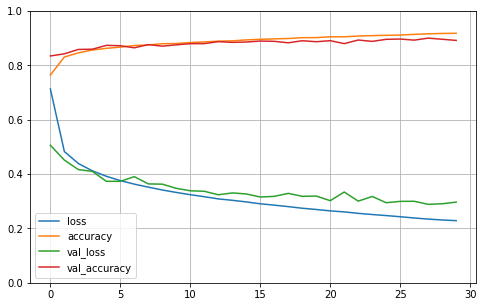

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

성능이 만족스럽지 못하다면 처음으로 돌아가 하이퍼파라미터들을 수정해 볼 수 있다.

- 학습률 조정
- Optimizer 변경해보기
- 레이어 개수, 레이어 당 뉴런 개수, 활성 함수 종류 변경 등

모델의 정확도가 만족스럽다면 상용 환경으로 배포하기 전에 테스트 세트로 모델을 평가해 일반화 오차를 추정해야 한다.

In [11]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.3363 - accuracy: 0.8787


[0.3362969756126404, 0.8787000179290771]

#### 모델을 사용해 예측 만들기
모델의 `predict()` 메서드를 사용해 새로운 샘플에 대해 예측을 만들 수 있다.
또는 `predict_classes()` 메소드를 사용해 가장 높은 확률을 갖는 클래스를 알 수 있다.

In [12]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99],
       [0.  , 0.  , 0.97, 0.  , 0.03, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [13]:
y_pred = model.predict_classes(X_new)
y_pred, y_test[:3]

c:\users\moogi\code\hknu4-artifical-inteligence\venv\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


(array([9, 2, 1], dtype=int64), array([9, 2, 1], dtype=uint8))

### 10.2.3 시퀀셜 API를 사용하여 회귀용 다층 퍼셉트론 만들기
캘리포니아 주택 가격 데이터셋을 신경망으로 해결해 보자.

In [14]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.fit_transform(X_valid)
X_test = scaler.fit_transform(X_test)

시퀀셜 API를 이용해 회귀용 MLP를 구축, 훈련, 평가, 예측하는 것은 분류에서 했던 것과 매우 비슷합니다.
주된 차이점은 출력층이 활성화 함수가 없는 하나의 뉴런을 가진다는 것과 손실함수로 평균 제곱 오차를 사용한다는 것이다.
이 데이터셋에는 잡음이 많기 때문에 과대적합을 막는 용도로 뉴런 수가 적은 은닉층 하나만 사용한다.

In [15]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])

model.compile(loss="mean_squared_error", optimizer="sgd")
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 0.8595 - val_loss: 1.0735
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6998 - val_loss: 0.6495

시퀀셜 API는 사용하기 쉽지만 더 복잡한 네트워크를 만들어야 할 수도 있다.